In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis

#import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
#from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import matplotlib.pyplot as plt

from bs4 import BeautifulSoup

import geocoder

<h3> identifying towns in Hudson Valley </h3>

In [2]:
url = 'https://www.discoverupstateny.com/packages/?region=hudson-valley&category=cities-towns'

In [3]:
req = requests.get(url)
soup=BeautifulSoup(req.content,'html5lib')
#print(soup.prettify())

In [4]:
body=soup.find('body')
#print(title)

In [5]:
tag = body.find_all('div', attrs={'class': 'package-search-title'})
#print(tag)

In [6]:
towns=[]
for t in tag:
    try:
        name=t.text.strip()
        towns.append(name)
    except:
        next

In [7]:
df=pd.DataFrame(towns)
df.columns = ['Town']
df.head()

,Town
0,Beacon
1,Cold Spring
2,Kingston
3,New Paltz
4,Poughkeepsie


In [8]:
df2 = pd.DataFrame(['Hudson','Woodstock','Highland','Nyack','Rhinebeck'], columns=['Town'])

In [9]:
df = df.append(df2,ignore_index=True)

In [10]:
df.shape

(13, 1)

<h3>Finding Coordinates of the Towns </h3>

In [11]:
latitude=[]
longitude=[]
geolocator = Nominatim(user_agent="ny_explorer")

# initialize your variable to None
lat_lng_coords = None
# loop until you get the coordinates
for town in df['Town']:
    location = geolocator.geocode('{}, NY'.format(town))
    latitude_coords = location.latitude
    longitude_coords = location.longitude
    #print('The geograpical coordinate of {} are {}, {}.'.format(town,latitude_coords, longitude_coords))
    latitude.append(latitude_coords)
    longitude.append(longitude_coords)

In [12]:
df['Latitude'] = latitude
df['Longitude'] = longitude
df

,Town,Latitude,Longitude
0,Beacon,41.504879,-73.969682
1,Cold Spring,41.420094,-73.954583
2,Kingston,41.928781,-74.002370
3,New Paltz,41.746497,-74.084489
4,Poughkeepsie,41.706554,-73.928367
5,Saugerties,42.077591,-73.952913
6,Sleepy Hollow,41.090859,-73.868071
7,White Plains,41.033986,-73.762910
8,Hudson,42.252865,-73.790959
9,Woodstock,42.041058,-74.118249


<h3>Showing Towns on Map</h3>

In [13]:
address = 'Hudson Valley'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Hudson Valley are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Hudson Valley are 41.31611085, -74.12629189225156.


In [14]:
# create map of Toronto using latitude and longitude values
map_hudson = folium.Map(location=[latitude, longitude], zoom_start=8)

# add markers to map
for lat, lng, town in zip(df['Latitude'], df['Longitude'], df['Town']):
    label = '{}'.format(town)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hudson)  
    
map_hudson

<h3>Exploring Towns</h3>

In [15]:
CLIENT_ID = '22SK3YVFFCQYZNZWNMQZ3GJKJT2YWP5FYYIOAE2YO0CE55AI' # your Foursquare ID
CLIENT_SECRET = 'CC1F5DCKC1MYEP0YZWWRDGHCW4D1LIWP4H4KH4VRBSHR50OY' # your Foursquare Secret
ACCESS_TOKEN = 'HPH2V3AKCZNMZEURLLLFUGLH3G1TSE4NHA31XREYIYBFFP3S' # your FourSquare Access Token
VERSION = '20210422' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 22SK3YVFFCQYZNZWNMQZ3GJKJT2YWP5FYYIOAE2YO0CE55AI
CLIENT_SECRET:CC1F5DCKC1MYEP0YZWWRDGHCW4D1LIWP4H4KH4VRBSHR50OY


In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=50000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore'
 
        params = {
            'client_id': CLIENT_ID,
            'client_secret': CLIENT_SECRET,
            'v': VERSION,
            'll': '{lat},{lon}'.format(lat=lat, lon=lng),
            'radius': radius,
            'limit': LIMIT,
            'section': 'trending,nextVenues,topPicks' #only include most relevant venues
        }            
        # make the GET request
        results = requests.get(url,params).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Town', 
                  'Town Latitude', 
                  'Town Longitude',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
venues = getNearbyVenues(df['Town'], df['Latitude'], df['Longitude'], radius=50000)

In [18]:
venues.groupby('Town').count()

,Town Latitude,Town Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Town,,,,,,
Beacon,100,100,100,100,100,100
Cold Spring,100,100,100,100,100,100
Highland,100,100,100,100,100,100
Hudson,100,100,100,100,100,100
Kingston,100,100,100,100,100,100
New Paltz,100,100,100,100,100,100
Nyack,100,100,100,100,100,100
Poughkeepsie,100,100,100,100,100,100
Rhinebeck,100,100,100,100,100,100


In [19]:
print('There are {} uniques categories.'.format(len(venues['Venue Category'].unique())))

There are 131 uniques categories.


In [20]:
# one hot encoding
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['Town'] = venues['Town']

# move neighborhood column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

onehot.shape

(1300, 132)

In [21]:
onehot.head()

,Town,American Restaurant,Antique Shop,Art Gallery,Art Museum,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Field,...,Thai Restaurant,Theater,Tourist Information Center,Trail,Vegetarian / Vegan Restaurant,Waterfront,Wine Bar,Wine Shop,Winery,Zoo
0,Beacon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Beacon,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Beacon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Beacon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Beacon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
grouped = onehot.groupby('Town').mean().reset_index()
grouped.shape

(13, 132)

In [23]:
#function to sort types of venue in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [24]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Town']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['Town'] = grouped['Town']

for ind in np.arange(grouped.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

venues_sorted

,Town,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Beacon,Trail,Brewery,Scenic Lookout,Italian Restaurant,Bar,Ice Cream Shop,Café,Grocery Store,Farm,Farmers Market
1,Cold Spring,Trail,Brewery,Scenic Lookout,American Restaurant,Grocery Store,Bar,Italian Restaurant,Café,Coffee Shop,Golf Course
2,Highland,Brewery,Trail,Café,Farmers Market,Grocery Store,Restaurant,Coffee Shop,Italian Restaurant,French Restaurant,Bar
3,Hudson,American Restaurant,Trail,Café,Brewery,Farm,Bakery,Deli / Bodega,Scenic Lookout,Italian Restaurant,Ice Cream Shop
4,Kingston,Café,Ice Cream Shop,Brewery,Italian Restaurant,American Restaurant,Trail,Bakery,Scenic Lookout,Deli / Bodega,Farmers Market
5,New Paltz,Trail,Farmers Market,Café,Brewery,Coffee Shop,Bakery,Grocery Store,Pizza Place,Sushi Restaurant,Farm
6,Nyack,Park,Bakery,Pizza Place,Gym,Plaza,Scenic Lookout,Ice Cream Shop,State / Provincial Park,Garden,Trail
7,Poughkeepsie,Café,Brewery,Farmers Market,Trail,Bar,French Restaurant,Grocery Store,Coffee Shop,Restaurant,American Restaurant
8,Rhinebeck,Café,Brewery,American Restaurant,Italian Restaurant,Trail,Bakery,Farmers Market,Ice Cream Shop,Deli / Bodega,Scenic Lookout
9,Saugerties,American Restaurant,Café,Italian Restaurant,Scenic Lookout,Trail,Brewery,Ice Cream Shop,Hotel,Cheese Shop,Deli / Bodega


<h3>Clustering</h3>

In [25]:
clustering = grouped.drop(['Town'], 1)

In [26]:
#find best K
distortions = []
K = range(1,7)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(clustering)
    distortions.append(kmeanModel.inertia_)

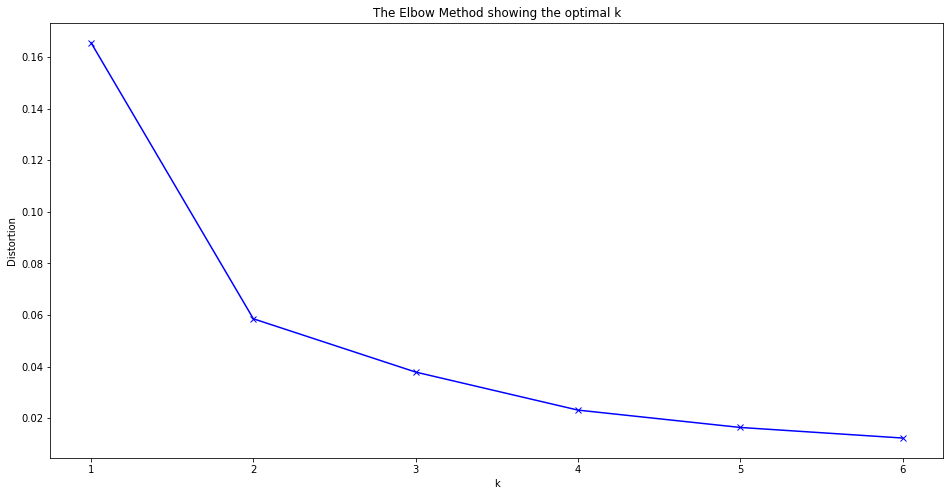

In [27]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [28]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:8] 

array([2, 2, 2, 0, 0, 2, 1, 2])

In [29]:
# add clustering labels
venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

town_merged = df

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
town_merged = town_merged.join(venues_sorted.set_index('Town'), on='Town')

town_merged # check the last columns!

,Town,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Beacon,41.504879,-73.969682,2,Trail,Brewery,Scenic Lookout,Italian Restaurant,Bar,Ice Cream Shop,Café,Grocery Store,Farm,Farmers Market
1,Cold Spring,41.420094,-73.954583,2,Trail,Brewery,Scenic Lookout,American Restaurant,Grocery Store,Bar,Italian Restaurant,Café,Coffee Shop,Golf Course
2,Kingston,41.928781,-74.002370,0,Café,Ice Cream Shop,Brewery,Italian Restaurant,American Restaurant,Trail,Bakery,Scenic Lookout,Deli / Bodega,Farmers Market
3,New Paltz,41.746497,-74.084489,2,Trail,Farmers Market,Café,Brewery,Coffee Shop,Bakery,Grocery Store,Pizza Place,Sushi Restaurant,Farm
4,Poughkeepsie,41.706554,-73.928367,2,Café,Brewery,Farmers Market,Trail,Bar,French Restaurant,Grocery Store,Coffee Shop,Restaurant,American Restaurant
5,Saugerties,42.077591,-73.952913,0,American Restaurant,Café,Italian Restaurant,Scenic Lookout,Trail,Brewery,Ice Cream Shop,Hotel,Cheese Shop,Deli / Bodega
6,Sleepy Hollow,41.090859,-73.868071,1,Park,Bakery,Pizza Place,Gym,State / Provincial Park,Ice Cream Shop,Plaza,Scenic Lookout,Garden,Trail
7,White Plains,41.033986,-73.762910,1,Park,Bakery,Gym,Pizza Place,Plaza,State / Provincial Park,Garden,Ice Cream Shop,Butcher,Theater
8,Hudson,42.252865,-73.790959,0,American Restaurant,Trail,Café,Brewery,Farm,Bakery,Deli / Bodega,Scenic Lookout,Italian Restaurant,Ice Cream Shop
9,Woodstock,42.041058,-74.118249,0,Bakery,American Restaurant,Café,Trail,Restaurant,Italian Restaurant,Deli / Bodega,Hotel,Brewery,Farmers Market


In [30]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=8)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(town_merged['Latitude'], town_merged['Longitude'], town_merged['Town'], town_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [31]:
town_merged["Cluster Labels"].replace({0: "Big Outdoor Town", 1: "Suburban Town",2:"Hiking Town"}, inplace=True)
town_merged

,Town,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Beacon,41.504879,-73.969682,Hiking Town,Trail,Brewery,Scenic Lookout,Italian Restaurant,Bar,Ice Cream Shop,Café,Grocery Store,Farm,Farmers Market
1,Cold Spring,41.420094,-73.954583,Hiking Town,Trail,Brewery,Scenic Lookout,American Restaurant,Grocery Store,Bar,Italian Restaurant,Café,Coffee Shop,Golf Course
2,Kingston,41.928781,-74.002370,Big Outdoor Town,Café,Ice Cream Shop,Brewery,Italian Restaurant,American Restaurant,Trail,Bakery,Scenic Lookout,Deli / Bodega,Farmers Market
3,New Paltz,41.746497,-74.084489,Hiking Town,Trail,Farmers Market,Café,Brewery,Coffee Shop,Bakery,Grocery Store,Pizza Place,Sushi Restaurant,Farm
4,Poughkeepsie,41.706554,-73.928367,Hiking Town,Café,Brewery,Farmers Market,Trail,Bar,French Restaurant,Grocery Store,Coffee Shop,Restaurant,American Restaurant
5,Saugerties,42.077591,-73.952913,Big Outdoor Town,American Restaurant,Café,Italian Restaurant,Scenic Lookout,Trail,Brewery,Ice Cream Shop,Hotel,Cheese Shop,Deli / Bodega
6,Sleepy Hollow,41.090859,-73.868071,Suburban Town,Park,Bakery,Pizza Place,Gym,State / Provincial Park,Ice Cream Shop,Plaza,Scenic Lookout,Garden,Trail
7,White Plains,41.033986,-73.762910,Suburban Town,Park,Bakery,Gym,Pizza Place,Plaza,State / Provincial Park,Garden,Ice Cream Shop,Butcher,Theater
8,Hudson,42.252865,-73.790959,Big Outdoor Town,American Restaurant,Trail,Café,Brewery,Farm,Bakery,Deli / Bodega,Scenic Lookout,Italian Restaurant,Ice Cream Shop
9,Woodstock,42.041058,-74.118249,Big Outdoor Town,Bakery,American Restaurant,Café,Trail,Restaurant,Italian Restaurant,Deli / Bodega,Hotel,Brewery,Farmers Market
